In [3]:
from IPython.display import Image

**Pondernet: Recurrent Network Halting**

*Problem Statement:*
   - In neural networks the amount of computation used grows with the size of the inputs, but often not with the complexity of the problem being learned.
   - Create an algorithm that learns the number of computation steps needed based on the complexity of the task while still acheiving high prediction accuracy

*Past Work:*
   - Adaptive Computation Time (ACT) for Recurrent Neural Networks (https://arxiv.org/pdf/1603.08983.pdf)
       - Automatically learns to scale the required computation time via a scalar halting probability
       - Unstable, and sensitive to choice of hyper-parameter to tradeoff between accuracy and computation cost

*Concepts:*
   - The time required to solve a problem is a function of more than just the size of the inputs
   - Most machine learning algorithms do not adjust their computational budget based on the complexity of the task
       - Most often this work is done manually by the data scientist
   - Pondernet has the ability to stop its computation effort if it deems the neural network has already learned enough that additional training isnt necessary.
   - Low-variance, unbiased gradient estimates
        - Fully differentiable
        - Define halting policy as a probablistic model
        - Compute overall probability of halting at each step as a geometric distribution
   - Inference
       - probabilstic both in term of number of computational steps and the prediction produced by the network

*Architecture:*
   - Pondernets halting policy is injected into the activation function
       - Thus, making this method applicable to other simple and complex neural network architectures
   - Step function
       - $ \hat{y}_{n}, h_{n+1}, {\lambda}_{n} = s(x, h_{n})$
       - where $ s $ can be any neural network
       - and, $ \hat{y}_{n} $ is the output of the network, $ {\lambda}_{n} $ is the probability of halting at step n, and $ h_{n+1} $ is the new state
   - Conditional Halting
       - Conditional probability of entering state 'halt' at step n conditioned that there has been no previous halt is defined as ...
       - Define Bernoulli random variable in order to represent a Markov process for halting
       - $ P({\Lambda}_{n} = 1 {\mid} {\Lambda}_{n-1} = 0) = {\lambda}_{n},  {\forall} 1 {\leq} n {\leq} N $
   - Loss Function
       - $ L = $$\sum_{n=1}^{N} p_{n} L(y, y^{n}) + BKL(p_{n}{\parallel}p_{G}({\lambda}_{p})) $
   - Reconstruction Loss
       - This value represents the expectation of loss L across halting steps
   - Regularization Loss
       - KL Divergence against geometric distribution parameterized by $ {\lambda}_{n} $
       - Biases the network towards the expected prior number of steps
       - It provides an incentive to give a non-zero probability to all possible number of steps, thus promoting exploration

*Parity Task:*
   - Task created from the paper Adaptive Computation Time for Recurrent Neural Networks
   - The input of the parity task is a vector of 0's, -1's, and 1's.
   - The output is the parity of 1's.
       - One if there is an odd number of 1's and zero otherwise

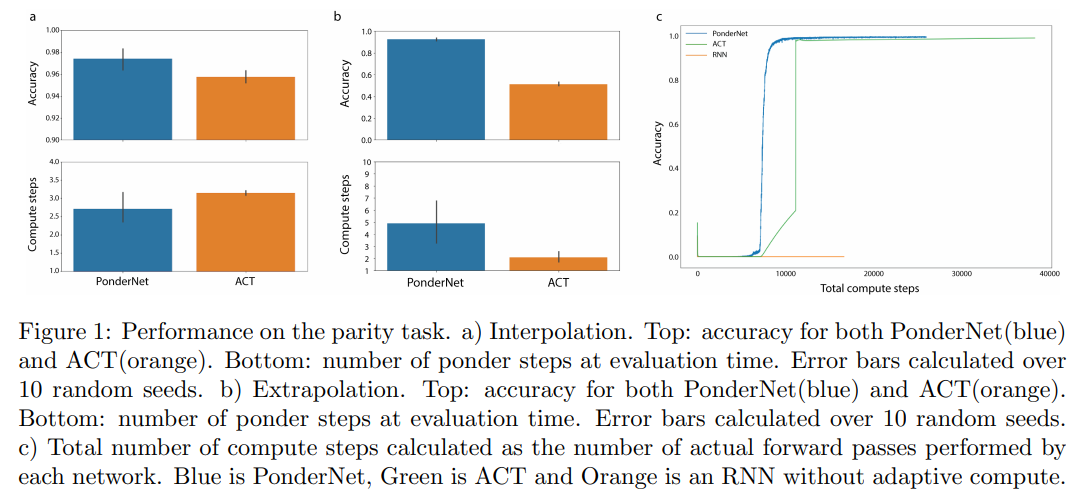

In [4]:
Image("images/pondernet_chart_1.PNG")

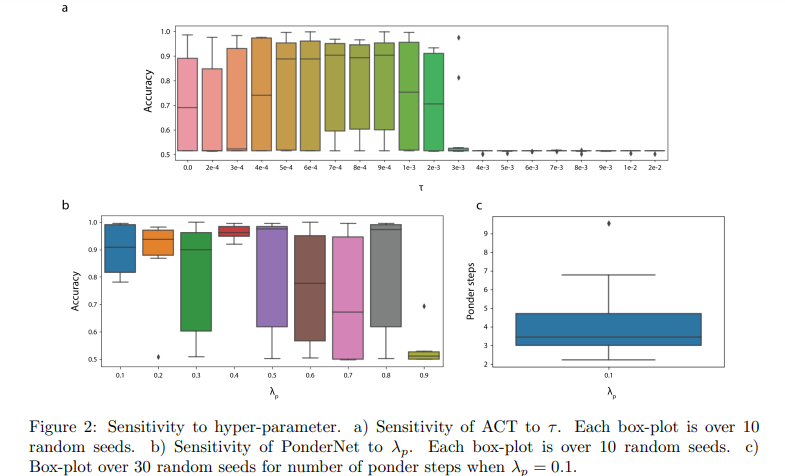

In [5]:
Image("images/pondernet_chart_2.PNG")

*bAbI Task:*
   - Collection of 20 nlp related tasks, most involving question-and-answer type questions
   - The example below is a "single supporting task" task:

        1 Mary moved to the bathroom.
        2 John went to the hallway.
        3 Where is Mary? 	bathroom	1
        4 Daniel went back to the hallway.
        5 Sandra moved to the garden.
        6 Where is Daniel? 	hallway	4
        7 John moved to the office.
        8 Sandra journeyed to the bathroom.
        9 Where is Daniel? 	hallway	4
        10 Mary moved to the hallway.
        11 Daniel travelled to the office.
        12 Where is Daniel? 	office	11
        13 John went back to the garden.
        14 John moved to the bedroom.
        15 Where is Sandra? 	bathroom	8

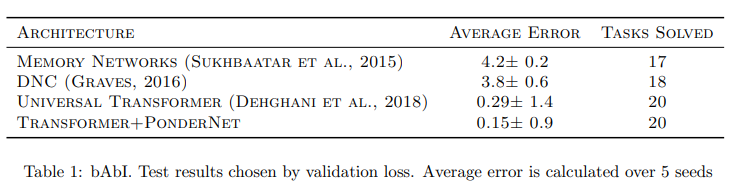

In [12]:
Image("images/pondernet_results_1.PNG")

*Paired Inference Task:*
   - https://arxiv.org/pdf/2001.10913.pdf
       - https://github.com/deepmind/deepmind-research/blob/master/memo/load_memo_data.ipynb

In [4]:
# Parity Task

from typing import Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader

# ! pip install labml-nn

from labml import experiment
from labml_helpers.module import Module
from labml_helpers.train_valid import SimpleTrainValidConfigs
from labml_helpers.metrics.accuracy import AccuracyDirect
from labml_nn.adaptive_computation.parity import ParityDataset

In [5]:
class ParityPonderGRU(Module):
    """
    
    Parameters
    ----------
    n_elems: int
        number of elements in the input vector
    n_hidden: int
        state vector size of the nn
    max_steps:
        maximum number of steps    
    """
    def __init__(self, n_elems: int, n_hidden: int, max_steps: int):
        super().__init__()
        self.max_steps = max_steps
        self.n_hidden = n_hidden
        
        # Define Gated Recurrent Unit
        self.gru = nn.GRUCell(n_elems, n_hidden)
        
        self.output_layer = nn.Linear(n_hidden, 1)
        self.lambda_layer = nn.Linear(n_hidden, 1)
        self.lambda_prob = nn.Sigmoid()
        
        # Option to set during inference so computation is halted
        self.is_halt = False
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward implementation.
        
        Parameters
        ----------
        x: torch.Tensor    
        
        Returns
        -------
        p, y, pm, ym = Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
        """
        batch_size = x.shape[0]
        
        # Get initial state
        h = x.new_zeros((x.shape[0], self.n_hidden))
        h = self.gru(x, h)
        
        # Lists to store p and y point estimates
        p, y = [], []
        
        un_halted_prob = h.new_ones((batch_size,))
        
        # Tensor to maintain which samples have halted computation
        halted = h.new_zeros((batch_size,))
        p_m = h.new_zeros((batch_size,))
        y_m = h.new_zeros((batch_size,))
        
        # Start stepping
        for n in range(1, self.max_steps + 1):
            
            if n == self.max_steps:
                # Halting probability for last step equals 1.0
                lambda_n = h.new_ones(h.shape[0])
            else:
                # Halting probability at step n
                lambda_n = self.lambda_prob(self.lambda_layer(h))[:, 0]
            
            # Model output at step n
            y_n = self.output_layer(h)[:, 0]
            
            # Geometric probability of halting at step n
            p_n = un_halted_prob * lambda_n
            un_halted_prob = un_halted_prob * (1 - lambda_n)
            
            # Halt based on probability
            halt = torch.bernoulli(lambda_n) * (1 - halted)
            
            # Collect p and y point estimates
            p.append(p_n)
            y.append(y_n)
            
            # Update pm and ym based on what was halted at step n
            p_m = p_m * (1 - halt) + p_n * halt
            y_m = y_m * (1 - halt) + y_n * halt
            
            # Update halted samples
            halted += halt
            
            # Get next state
            h = self.gru(x, h)
            
            # Stop computation if all samples have been halted
            if self.is_halt and halted.sum() == batch_size:
                break
        return torch.stack(p), torch.stack(y), p_m, y_m

In [8]:
class ReconstructionLoss(Module):
    """
    Normal loss between target y and prediction yn.
    
    Parameters
    ----------
    loss_func: nn.Module    
    """
    def __init__(self, loss_func: nn.Module):
        super().__init__()
        self.loss_func = loss_func
        
    def forward(self, p: torch.Tensor, y_hat: torch.Tensor, y: torch.Tensor):
        """
        Forward implementation
        
        Parameters
        ----------
        p: torch.Tensor
        y_hat: torch.Tensor
        y: torch.Tensor
        
        Returns
        -------
        total_loss: torch.Tensor        
        """
        total_loss = p.new_tensor(0.)
        for n in range(p.shape[0]):
            loss = (p[n] * self.loss_func(y_hat[n], y)).mean()
            total_loss += loss
        return total_loss

In [9]:
class RegularizationLoss(Module):
    """
    Kullback-Leibler divergence
    
    Parameters
    ----------
    lambda_p: float
        Success probability of geometric distribution
    max_steps: int
    """
    def __init__(self, lambda_p: float, max_steps: int = 1000):
        super().__init__()
        
        # Build the geometric distribution
        p_g = torch.zeros((max_steps, ))
        not_halted = 1.
        for k in range(max_steps):
            p_g[k] = not_halted * lambda_p
            not_halted = not_halted * (1 - lambda_p)
        self.p_g = nn.Parameter(p_g, requires_grad=False)
        
        # Define KL Divergence loss
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        
    def forward(self, p: torch.Tensor):
        """
        Forward implementation.
        
        Parameters
        ----------
        p: torch.Tensor
        
        Returns
        -------
        kl_div:         
        """
        p = p.transpose(0, 1)
        p_g = self.p_g[None, :p.shape[1]].expand_as(p)
        return self.kl_div(p.log(), p_g)

In [10]:
class Configs(SimpleTrainValidConfigs):
    
    # Define training parameters
    epochs = 10
    n_batches = 5
    batch_size = 128
    
    # Define model parameters
    model: ParityPonderGRU
    n_elems = 8
    n_hidden = 64
    max_steps = 20
    lambda_p = 0.2
    beta = 0.01
    grad_norm_clip = 1.0
        
    # Define losses
    loss_rec: ReconstructionLoss
    loss_reg: RegularizationLoss
    
    # Define accuracy 
    accuracy = AccuracyDirect()
    
    def init(self):
        self.state_modules = [self.accuracy]
        
        # Instantiate model
        self.model = ParityPonderGRU(self.n_elems, self.n_hidden, self.max_steps).to(self.device)
        
        # Instantiate losses
        self.loss_rec = ReconstructionLoss(nn.BCEWithLogitsLoss(reduction="none")).to(self.device)
        self.loss_reg = RegularizationLoss(self.lambda_p, self.max_steps).to(self.device)
        
        # Instantiate dataloaders
        self.train_loader = DataLoader(
            ParityDataset(self.batch_size * self.n_batches, self.n_elems), 
            batch_size=self.batch_size
        )
        self.valid_loader = DataLoader(
            ParityDataset(self.batch_size * 32, self.n_elems), 
            batch_size=self.batch_size
        )
        
    def step(self, batch, batch_idx):
        """
        
        Parameters
        ----------
        batch: torch.Tensor
        batch_idx: int
        
        Returns
        -------
        None
        """
        self.model.train(self.mode.is_train)
        data, target = batch[0].to(self.device), batch[1].to(self.device)
        p, y_hat, p_sampled, y_hat_sampled = self.model(data)
        
        # Calculate the reconstruction loss
        loss_rec = self.loss_rec(p, y_hat, target.to(torch.float))
        
        # Calculate the regularization loss
        loss_reg = self.loss_reg(p)
        
        loss = loss_rec + self.beta * loss_reg
        
        # Calculate the number of expected steps taken
        steps = torch.arange(1, p.shape[0] + 1, device=p.device)
        expected_steps = (p * steps[:, None]).sum(dim = 0)
        self.accuracy(y_hat_sampled > 0, target)
        
        # Compute and clip gradients, then optimize
        if self.mode.is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.grad_norm_clip)
            self.optimizer.step()
            self.optimizer.zero_grad()

In [11]:
def main():
    experiment.create(name="pondernet")
    conf = Configs()
    experiment.configs(conf, {
        'optimizer.optimizer': 'Adam',
        'optimizer.learning_rate': 0.0003
    })
    with experiment.start():
        conf.run()

main()